In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from io import BytesIO
import requests
import pingouin as pg

from tqdm.auto import tqdm
import seaborn as sns

from datetime import timedelta
from datetime import datetime

from airflow import DAG
from airflow.decorators import dag, task

plt.style.use('ggplot')

### Анализ входных данных ###

In [5]:
# Посмотрим на данные о распределении тестовой и контрольной групп
req1 = requests.get('https://s08vlx.storage.yandex.net/rdisk/8b683f76025c5bf7b1badd2c6859171800ffa09b8796b2a8e713d5b7d1918709/63209342/fKqInKw3d7bLFOeFnMGnhLWIS9AmXMMXWGR17A-BkO3-qg5Wp8tUAp7lxoJJvJyG8pjltSuuxShICmGl2FDiJhbsM4PC04KdB-NoZUjfeOOr8npumZHI4midPdWhecNq?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_groups.csv&disposition=attachment&hash=FjLs%2B6AJdyaRoyFMFeL4raj9RoBP3hYIuXfguWvuEGcjdjYEIrmN7ZN/eZ32Z77Cq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=724984&hid=4b9098e1d545e562c779de19f9f64e2f&media_type=spreadsheet&tknv=v2&rtoken=aTE0kCXZNHIP&force_default=no&ycrid=na-d3635131a928a2c7b8c603745d05bf0a-downloader16h&ts=5e88fcef9d480&s=0e45dc55fe9181d294d5ef8d3aabedb8c6bf7bbd35db78f3c395180e30f525e7&pb=U2FsdGVkX1-6VB28x0NC8BEpsXYiVFgu6NIWKdJr1w4Z56HZIxvh_a-arAWCzrVW2oifz3ekGOIfq-C0iG-A7nCuu_3eNutzRlHA6UdqzOGsJajRGKqPL9EYxP4kT3vU')
df_groups = pd.read_csv(BytesIO(data1), sep = ';')

In [5]:
df_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# пропущенные значения отсутствуют, все пользователи распределены по группам
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [34]:
# численное распределение пользователей по группам неравномерное, очень странно, что целевая группа настолько больше контрольной
df_groups.groupby('grp', as_index = False).count()

,grp,id
0,A,14671
1,B,59813


In [9]:
# проверим на повторы айдишников
df_groups.id.duplicated().sum()

0

Имеется фрейм с уникальными айдишками 74484 юзеров, поделенных на тестовую и контрольную группы. Разделение этих групп кажется странным: раскатывать изменения на большой группе пользователей, и брать размер контроля только 25% от теста. Хотелось бы взглянуть на систему сплитования как минимум.

In [ ]:
# рассмотрим данные о новых юзерах, присланные через 2 дня
req4 = requests.get('https://s750sas.storage.yandex.net/rdisk/f06bf3fb0ce3d7ed783c715aa18a0389af6e9d4efa00d64ca5f53aac6182abf1/62ffc01e/fKqInKw3d7bLFOeFnMGnhGAdJ2MSdW82i4_ghmwgsZlWhJkpRytn07Ls4kX484X-lezQy4loqSz9AFrIeHDnv8QEHwKSTiYbb_hzq1q6XQir8npumZHI4midPdWhecNq?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_group_add.csv&disposition=attachment&hash=0ertv33lnyTdzTu9NbdN9MtgpuTSXleSHZ%2BvhK85v05jGwJs7DHSrj4ununKsRcfq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=949&hid=e8dcec35987c367a56f82404a22463b7&media_type=spreadsheet&tknv=v2&rtoken=x7sQvDBvEcVd&force_default=no&ycrid=na-6ae8cf4f9feb8da91b76dd02295986e5-downloader2e&ts=5e69af139c380&s=28a8f791e2b55bce136323bbd03a635c3fae77f3b10cbcaff7b7a06d71e43fd6&pb=U2FsdGVkX18Wzaw8soN5pjC05gU8iWY8NCgpwE3Bgchzktb4Mdsjxki6tJpzFvDFmTxaIG_MODh8nBJa5LDlTyyWkkVUpW84A0_EDWJ33f5Fytt1LWGLsoVjXXtP2sIv')
data4 = req4.content
df_groups_add = pd.read_csv(BytesIO(data4))

In [11]:
df_groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
# аналогично, пропущенные значения отсутствуют, все пользователи распределены по группам
df_groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [38]:
# численное распределение пользователей по группам: около 30% юзеров относятся к контрольной группе, и 70% - к тестовой
df_groups_add.groupby('grp', as_index = False).count()

,grp,id
0,A,22
1,B,70


In [20]:
# проверим на повторы айдишников
df_groups_add.id.duplicated().sum()

0

Аналогично основной группе, добавочная оказалась из уникальных айдишников 92 юзеров, все поделены на тест и контроль. Соотношение деления все такое же странное. Учитывая, что изменение/доработка системы оплаты сколько-то стоит (в отличие от отсутствия изменений как таковых), можно подумать, что описание датафрейма неверно, и А - группа тестовая, а В - контрольная. Ну или тест на самом деле ухудшающий (правда, не могу придумать пример в рамках системы оплаты). В любом случае, **сплитование вызывает вопросы**.

In [5]:
# получим общий итоговый фрейм по распределению юзеров
df_groups_total = pd.concat([df_groups, df_groups_add])

In [8]:
df_groups_total.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
# видим, что размер общего фрейма как раз равен сумме строчек df_groups и df_groups_add, все ок
df_groups_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [7]:
# переименуем колонку с айдишниками пользователей для удобного использования
df_groups_total = df_groups_total.rename(columns={'id' : 'student_id'})

In [47]:
# все айдишники уникальны
df_groups_total.student_id.nunique()

74576

In [111]:
# посмотрим на активных пользователей в дни эксперимента
req2 = requests.get('https://s432vla.storage.yandex.net/rdisk/3a40f377f696432a2588a986b2af49044dd68afb5b18d69010f8282c1f40f146/62ffbec8/n3N0SQYM2SoDHEJIQgKt2ujEDw5jYN17sSz14UE4iwGyYlrHRmnPoV9WI8mqa1dmF6Qt_88ffG90wBmmEpDhFQ==?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_active_studs.csv&disposition=attachment&hash=zWS0uLxK3MRXd/4/IErmDFQBGvbpGD1qm/aJx/k6EUUtE6DaDI0uGkDT4cHh/WJbq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=65131&hid=3ed23002f82477fd8c7d4a21c17d8034&media_type=spreadsheet&tknv=v2&rtoken=VLQnNMBdZHav&force_default=no&ycrid=na-96300cdc146eb8e9f9841f7d1c03ae4f-downloader11f&ts=5e69adcd74200&s=298f3f9a6a0b4dcfcd30b5e2531375074e1817b4485c4e2acc2cdda94c064471&pb=U2FsdGVkX19nAru0O76sUeX5I7sjU7s3OfVwfBSgj3bVELERwhe44uxz5-Qbg-huJf5HKtETRz_t9FsHXfXWWfoU1L7utUUpsCWTRvpOBWo')
data2 = req2.content
df_active_studs = pd.read_csv(BytesIO(data2))

In [12]:
# мы видим перечень юзеров, которые заходили на платформу в дни эксперимента
df_active_studs.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [45]:
# 8341 юзер заходил на платформу в дни эксперимента
df_active_studs.shape

(8341, 1)

In [13]:
# все айдишники уникальны
df_active_studs.student_id.nunique()

8341

In [9]:
# для удобства добавим колонку с отметкой об активности юзеров
df_active_studs['activity'] = 'yes'

In [115]:
# посмотрим данные об оплате
req3 = requests.get('https://s251vla.storage.yandex.net/rdisk/2ed0cef7d3eeb388a1cfef16c898d547abd95ff3590fc483208d4d0329f39e40/62ffbf91/n3N0SQYM2SoDHEJIQgKt2psRrG10OKyAasqgpda4iX7NDTSjoP6nmHZtzOqJXgQH436kYOx6cWVM8zgvGq_zHg==?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_checks.csv&disposition=attachment&hash=TeGedpkC9yRvIkaaNDf1zC3bFkr2Kvo9MvW7kYjfHc5svktv83UZ47kn6%2BaauC1pq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=7764&hid=caf94adff3374e1c1a09fba3aae11e50&media_type=spreadsheet&tknv=v2&rtoken=lCY7FQdHOPMD&force_default=no&ycrid=na-5f259d0cfa6acec9fbf8a1703b68f794-downloader2e&ts=5e69ae8d24640&s=5e3efcf73091f37afe750f8ddb7beb1773a95e621febe7d1acb402b6068f975a&pb=U2FsdGVkX19V-bWbgCAsy4qge7CA2oQF6lBXPRtQz-MNZMZkdtcatn1jMBpFi1o_th5_ltM41rhn_qRsTsB_Kcy6rHTqxIQjj_CLNuwylEM')
data3 = req3.content
df_checks = pd.read_csv(BytesIO(data3), sep = ';')

In [48]:
df_checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
# в датафрейме имеются данные о 541 транзакции
df_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [55]:
# на каждого юзера приходится одна оплата
df_checks.student_id.nunique()

541

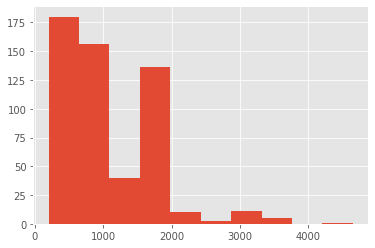

In [16]:
df_checks.rev.hist();

In [54]:
df_checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

В данном сете имеются данные о 541 транзакции 541 юзера. Предполагает ли система оплаты разовые платежи? Или наши данные представляют собой итоговые суммы платежей каждого юзера в исследуемый период? Не ясно, поэтому на будущее **метрики, учитывающие повторные платежи, мы использовать не будем**.  
Само распределение чеков скошено влево, минимальный чек составил 199, а максимальный - 4650. Половина пользователей платит больше 840.

### Анализ пользовательской активности и оплат ###

In [11]:
# получим общий датафрейм по активностям и оплатам
df_active_checks = df_active_studs.merge(df_checks, how = 'outer')

In [18]:
# обратим внимание, что итоговый датасет содержит 8490 строк, что больше, чем 8431 (число активных юзеров)
# можно предположить, что множество плативших клиентов не полностью пересекается с множеством активных
# значит, есть те, кто платил, но не активничал
df_active_checks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8490 entries, 0 to 8489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8490 non-null   int64  
 1   activity    8341 non-null   object 
 2   rev         541 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 265.3+ KB


In [19]:
# найдем юзеров, не вошедших в перечень активных, и при этом заплативших в дни эксперимента
df_active_checks[df_active_checks.activity.isna() & df_active_checks.rev>0]

,student_id,activity,rev
8341,3185,NaN,690.0
8342,25973,NaN,690.0
8343,26280,NaN,690.0
8344,100645,NaN,630.0
8345,102534,NaN,580.0
...,...,...,...
8485,5291900,NaN,199.0
8486,5331842,NaN,290.0
8487,5486319,NaN,199.0
8488,5562806,NaN,398.0


Есть 149 человек, которые **не были активны в дни эксперимента, но, тем не менее, оплатили приложение**. Посмотрим на разницу между группами активности, вдруг чего найдем.  
Для удобства заменим NA в активности на 'no', а NA в чеках на 0

In [12]:
df_active_checks.activity = df_active_checks.activity.fillna('no')
df_active_checks.rev = df_active_checks.rev.fillna(0)

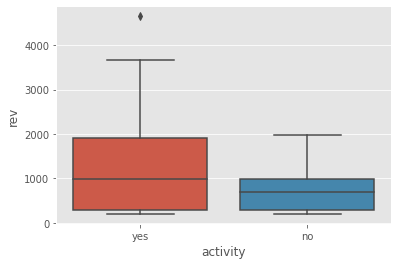

In [13]:
# посмотрим на размер чеков платящих юзеров среди активных и неактивных
sns.boxplot(x="activity", y="rev", data=df_active_checks.query('rev > 0'));

In [14]:
# величина средних чеков платящих активных и неактивных юзеров
df_active_checks.query('rev > 0') \
.groupby('activity', as_index = False) \
.agg({'rev' : 'mean'})

,activity,rev
0,no,708.268457
1,yes,1193.352050


Активные клиенты чаще просто не платили (из 8431 юзера оплаты прошли только у 392), однако, при сравнении активных и неактивных платящих клиентов на первый взгляд кажется, что первые платят больше - распределение их платежей сдвинуто вправо (половина активных платит больше 990, в то время как по неактивным медиана составила 690, также различны максимальные платежи и средние).

In [15]:
# посмотрим, как распределены тестовые группы внутри активных и неактивных юзеров
df_active_checks.merge(df_groups_total, how = 'left', on = 'student_id') \
.groupby(['activity', 'grp'], as_index = False) \
.agg({'student_id' : 'nunique'})

,activity,grp,student_id
0,no,A,29
1,no,B,120
2,yes,A,1538
3,yes,B,6803


Доли теста и контроля среди активных и неактивных, но платящих юзеров, примерно пропорциональны (в обеих группах порядка 80 процентов юзеров из тестовой группы).  
Тогда интересно, насколько статзначимо различаются средние чеки платящих пользователей. Потому что если различаются, то можно осторожно предположить, что это не техническая ошибка учета юзеров, а скорее продуктовая особенность, и неактивные оплаты - что-то вроде ранее оформленных подписок (в случае ошибки регистрации активности пользователей их поведение в среднем не должно было бы отличаться).Поэтому возьмем распределения чеков в обеих группах и:  
1. **проверим на нормальность**,  
2. если они нормальны, **применим t-test**,  
3. иначе **применим бутстрап** для оценки среднего чека (критерий **Манна - Уитни рассматривать даже не будем**, так как наши группы диспропорциональны, а Манн - Уитни такое не жалует),   
4. **гипотеза Н0 - различий между группами нет, альтернативная гипотеза - они есть**, и средние чеки значимо отличаются в зависимости от активности юзеров.

In [16]:
# проверка на нормальность чеков активных платящих пользователей
pg.normality(df_active_checks[(df_active_checks.activity == 'yes')&(df_active_checks.rev > 0)], method='normaltest')

,W,pval,normal
student_id,292.262222,3.436092e-64,False
rev,24.143654,5.718368e-06,False


In [17]:
# проверка на нормальность чеков неактивных платящих пользователей
pg.normality(df_active_checks[(df_active_checks.activity == 'no')&(df_active_checks.rev > 0)], method='normaltest')

,W,pval,normal
student_id,21.068820,2.660503e-05,False
rev,32.075438,1.083695e-07,False


Поскольку тест на нормальность показал p-value много меньше 0,05, считаем, что *оба распределения чеков значимо отличаются от нормального*. Применим бутстрап для оценки разницы ARPPU активных и неактивных пользователей:  
**- Н0: средние чеки платящих активных и неактивных пользователей стат значимо не различаются,**  
**- альтернативная гипотеза: между средними чеками платящих пользователей есть стат значимая разница**

In [18]:
# Объявим функцию, которая позволит проверять гипотезу о равенстве метрик
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_2), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

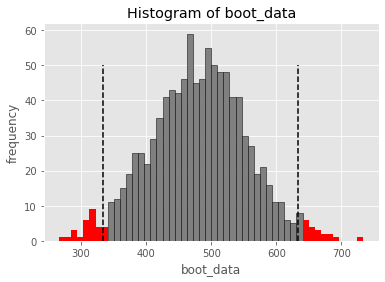

{'boot_data': [561.1342375838927,
  419.1275268456376,
  477.57047852349,
  431.49664899328866,
  476.4630979865773,
  568.3154469798658,
  472.82551275167793,
  494.3221530201341,
  456.30873758389293,
  390.4630932885907,
  406.4496758389263,
  486.7382617449663,
  454.577187919463,
  418.348997315436,
  464.21477382550347,
  455.7516838926175,
  380.00672080536924,
  545.8590731543621,
  551.3624241610739,
  426.1141040268458,
  542.543632214765,
  367.78524228187916,
  508.6443060402685,
  423.1812181208054,
  365.5570536912751,
  353.1140973154363,
  379.4496751677855,
  620.6308805369129,
  634.5906080536912,
  495.29530671140935,
  599.9597369127515,
  512.7449778523489,
  521.5570523489931,
  419.83893557046986,
  396.8926255033556,
  478.7583959731543,
  464.4228295302014,
  450.45638456375843,
  475.96645033557036,
  498.60403624161074,
  514.3087328859061,
  479.8322241610739,
  497.6375899328858,
  504.818801342282,
  559.0939738255033,
  542.6912852348994,
  384.8792020134

In [19]:
get_bootstrap(
    df_active_checks[(df_active_checks.activity == 'yes')&(df_active_checks.rev > 0)].rev, # числовые значения первой выборки
    df_active_checks[(df_active_checks.activity == 'no')&(df_active_checks.rev > 0)].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

p-value много меньше 0,05, следовательно имеется достаточно оснований отвергнуть основную гипотезу и принять альтернативную: *ARPPU активных и неактивных юзеров статзначимо различаются*. Предположим, что неактивные платящие пользователи - это ранее оформившие подписку и не заходившие в дни эксперимента на платформу.

Отсюда далее **имеет смысл рассматривать только активных юзеров**, поскольку мы хотим оценить метрики с точки зрения воздействия новой системы оплаты, и пользователи, которые даже не заходили на платформу в дни эксперимента, ясности картине не добавят.  
В любом случае, **для корректности оценки результатов А/Б теста необходимо разобраться с причиной данной ситуации**, поскольку из анализа вылетает почти треть платящих пользователей.

### Анализ тестовых групп ###

In [23]:
# удалим неактивных юзеров с оплатами
df_active_checks['to_del'] = np.where((df_active_checks.activity == "no") & (df_active_checks.rev > 0), 'del', 'no del')
df_active_checks = df_active_checks.query('to_del == "no del"')
df_active_checks.drop(columns = 'to_del', axis = 1, inplace = True)

In [24]:
# получим общий фрейм с экспериментальными группами, активностями и чеками
df = df_groups_total.merge(df_active_checks, how = 'outer', on = 'student_id')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  74576 non-null  int64  
 1   grp         74576 non-null  object 
 2   activity    8341 non-null   object 
 3   rev         8341 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.8+ MB


In [26]:
df.head()

,student_id,grp,activity,rev
0,1489,B,NaN,NaN
1,1627,A,yes,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [27]:
# для удобства заменим NA
df.activity = df.activity.fillna('no')
df.rev = df.rev.fillna(0)

In [32]:
df.head()

,student_id,grp,activity,rev
0,1489,B,no,0.0
1,1627,A,yes,990.0
2,1768,B,no,0.0
3,1783,B,no,0.0
4,1794,A,no,0.0


В случае, когда из 75 тысяч юзеров активными были 8431, и из них только 392 сделали покупку, ожидаемые распределения оплат внутри групп будут сильно скошены влево, с медианой около 0:

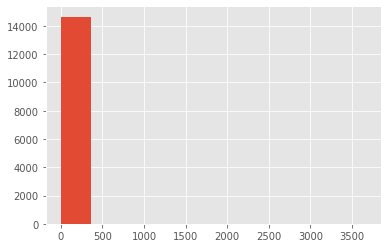

In [30]:
df.rev[df.grp == 'A'].hist();

In [31]:
df.rev[df.grp == 'A'].describe()

count    14693.000000
mean         4.956102
std         95.068422
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3660.000000
Name: rev, dtype: float64

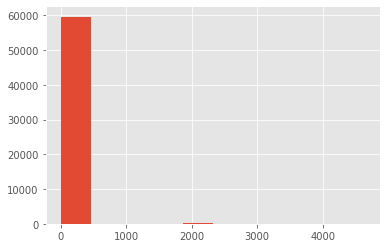

In [34]:
df.rev[df.grp == 'B'].hist();

In [48]:
df.rev[df.grp == 'B'].describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

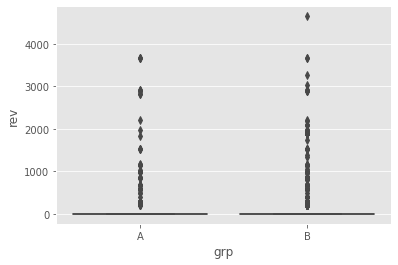

In [38]:
# среди активных юзеров тестовой группы имеются бОльшие чеки
sns.boxplot(x="grp", y="rev", data=df[df.activity == "yes"]);

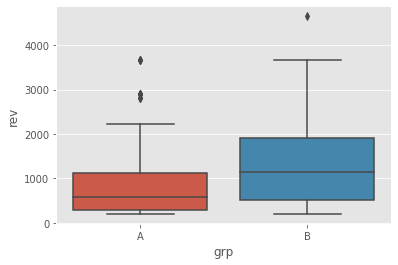

In [40]:
# в среднем платящий юзер теста имеет бОльший чек относительно контроля
sns.boxplot(x="grp", y="rev", data=df.query('rev > 0'));

### Расчет метрик ###

Ввиду того, что нам важно, изменила ли новая система оплаты поведение пользователей, стали ли они покупать чаще, или может быть больше, имеет смысл рассматривать следующие метрики:    
- **CR в покупку активных пользователей** (частота покупок),  
- **ARPAU** (средний чек активного пользователя),  
- **ARPPU** (средний чек платящего пользователя).  
ARPU считать не вижу смысла - оплат мало, пользователей много, метрика "размажется" и будет малочувствительной. Впрочем, конверсия скорее всего тоже не особо изменится по тем же причинам, но ее мы посчитаем как количественную метрику поведения юзеров. 

In [ ]:
# добавим колонку для сравнения CR (есть покупка - значение 1, иначе - 0)
df['CR'] = df.rev.apply(lambda x: 1 if x > 0 else 0)

In [46]:
# посчитаем указанные метрики:

# общее число юзеров
users_total = df.groupby('grp', as_index = False) \
.agg({'student_id' : 'nunique'}) \
.rename(columns = {'student_id' : 'users_total'})

# число платящих юзеров
users_rev = df.query('rev > 0') \
.groupby('grp', as_index = False) \
.agg({'student_id' : 'nunique'}) \
.rename(columns = {'student_id' : 'users_with_revenue'})

# число активных юзеров
users_active = df.query('activity == "yes"') \
.groupby('grp', as_index = False) \
.agg({'student_id' : 'nunique'}) \
.rename(columns = {'student_id' : 'users_active'})

# общая сумма платежей всех юзеров
rev_total = df.groupby('grp', as_index = False) \
.agg({'rev' : 'sum'}) \
.rename(columns = {'rev' : 'rev_total'})

# cумма платежей всех активных пользователей
users_active_rev = df.query('activity == "yes"') \
.groupby('grp', as_index = False) \
.agg({'rev' : 'sum'}) \
.rename(columns = {'rev' : 'users_active_rev'})

metrics = users_total.merge(rev_total, how = 'inner', on = 'grp') \
.merge(users_rev, how = 'inner', on = 'grp') \
.merge(users_active, how = 'inner', on = 'grp') \
.merge(users_active_rev, how = 'inner', on = 'grp')

metrics['CR'] = metrics.users_with_revenue / metrics.users_total
metrics['ARPAU'] = metrics.users_active_rev / metrics.users_active
metrics['ARPPU'] = metrics.rev_total / metrics.users_with_revenue

metrics

,grp,users_total,rev_total,users_with_revenue,users_active,users_active_rev,CR,ARPAU,ARPPU
0,A,14693,72820.0000,78,1538,72820.0000,0.005309,47.347204,933.589744
1,B,59883,394974.0035,314,6803,394974.0035,0.005244,58.058798,1257.878992


Кажется, что средние чеки активных и платящих пользователей действительно выросли, а конверсия практически не изменилась

### Проверка гипотез о стат значимом росте метрик ###

**Инструменты**:  
    - t-test (требует нормального распределения и равномерности дисперсий),  
    - Манн - Уитни (не любит диспропорции в сравниваемых выборках),  
    - бутстрап.  
Поскольку Манн - Уитни не подходит из-за различных размеров выборок, проверим распределение признаков на нормальность:

**Гипотезы**:  
- Н0: признак распределен нормально  
- Н1: распределение признака значимо отличается от нормального

In [47]:
# проверка на нормальность конверсии контрольной группы
pg.normality(df[df.grp == 'A'].CR, method='normaltest')

,W,pval,normal
CR,26541.521701,0.0,False


In [51]:
# проверка на нормальность конверсии тестовой группы
pg.normality(df[df.grp == 'B'].CR, method='normaltest')

,W,pval,normal
CR,108282.552677,0.0,False


In [48]:
# проверка на нормальность ARPAU контрольной группы
pg.normality(df[(df.grp == 'A')&(df.activity == "yes")].rev, method='normaltest')

,W,pval,normal
rev,2240.595797,0.0,False


In [52]:
# проверка на нормальность ARPAU тестовой группы
pg.normality(df[(df.grp == 'B')&(df.activity == "yes")].rev, method='normaltest')

,W,pval,normal
rev,7797.399212,0.0,False


In [49]:
# проверка на нормальность ARPPU контрольной группы
pg.normality(df[(df.grp == 'A')&(df.rev > 0)].rev, method='normaltest')

,W,pval,normal
rev,30.37842,2.531687e-07,False


In [53]:
# проверка на нормальность ARPPU тестовой группы
pg.normality(df[(df.grp == 'B')&(df.rev > 0)].rev, method='normaltest')

,W,pval,normal
rev,6.795663,0.033446,False


Во всех случаях значения p-value меньше 0,05, гипотеза о нормальном распределении признаков во всех случаях отвергается: **конверсия и оплаты активных и платящих пользователей ненормально распределены**  
Поэтому применим бутстрап:

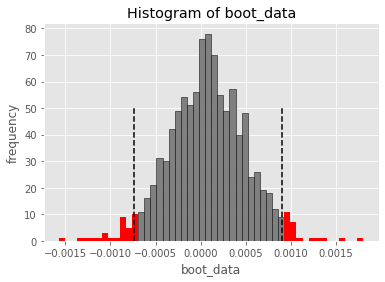

{'boot_data': [-0.00028388691281331854,
  -0.00010019538099293682,
  -0.00023378922231685143,
  0.0010019538099293622,
  5.009769049646798e-05,
  -0.00023378922231685056,
  -0.00013359384132391548,
  -0.00020039076198587278,
  0.0010019538099293622,
  0.0002671876826478301,
  -0.00025048845248234076,
  -0.00045087921446821267,
  -0.0002838869128133194,
  0.0010019538099293622,
  0.0003339846033097874,
  0.00018369153182038345,
  -0.00038408229380625537,
  -0.0002170899921513621,
  0.00025048845248234076,
  6.67969206619573e-05,
  0.00038408229380625537,
  -0.0002170899921513621,
  0.0008349615082744689,
  -8.349615082744663e-05,
  0.00015029307148940393,
  1.6699230165489326e-05,
  -3.339846033097865e-05,
  0.0002504884524823399,
  -0.00018369153182038259,
  0.0008683599686054467,
  0.0001335938413239146,
  0.00023378922231685056,
  -0.0005677738256266388,
  0.0006345707462885961,
  -0.00016699230165489413,
  0.0002003907619858719,
  1.6699230165489326e-05,
  -0.00018369153182038345,
 

In [54]:
# посмотрим на бутстрэп по CR в покупку среди активных пользователей
# Н0: конверсии в тестовой и контрольной группе значимо не различаются
# Н1: конверсии теста и контроля значимо отличны
get_bootstrap(
    df[df.grp == 'A'].CR, # числовые значения первой выборки
    df[df.grp == 'B'].CR, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

pvalue = 0.85, что не позволяет отвергнуть основную гипотезу: **между тестом и контролем по конверсии в покупку статистически значимых различий не наблюдается**

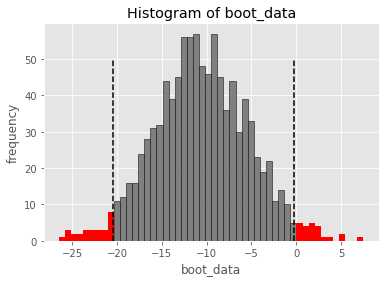

{'boot_data': [-16.4246659855946,
  -9.346171350874613,
  -8.111715934146694,
  -3.2247542701749268,
  -8.478613038365431,
  -7.768778979861828,
  -15.158753976186986,
  -14.093929722181393,
  -8.375864030574753,
  -17.379244862560633,
  -2.926062428340437,
  -11.123475363810087,
  -4.683522490077905,
  -2.774217683374985,
  -15.27532018227253,
  -2.134499867705422,
  -9.344113508746148,
  -12.265324694987513,
  -5.770248993091279,
  -7.889607996472151,
  -4.247832265177131,
  -7.549023019256218,
  -9.909158297809789,
  -12.47361521387623,
  -8.555490754079095,
  -18.368514508305168,
  -9.155961017198294,
  -10.039394972806122,
  -11.609437527561376,
  -3.757901558136119,
  -12.87093971777157,
  -9.533147773041307,
  -9.87387981772747,
  -16.45332978097899,
  -15.732177465823902,
  -12.12112351903572,
  -13.616199294428938,
  -10.843305041893274,
  -17.6907252976628,
  -16.93208934293694,
  -10.253565147728942,
  -14.33705765103631,
  -12.699544803763054,
  -5.608996575040422,
  -12.22

In [57]:
# посмотрим на бутстрэп по ARPAU
# Н0: средний чек активного юзера в тестовой и контрольной группе значимо не различаются
# Н1: средний чек активного юзера теста и контроля значимо отличны
get_bootstrap(
    df[(df.grp == 'A')&(df.activity == "yes")].rev, # числовые значения первой выборки
    df[(df.grp == 'B')&(df.activity == "yes")].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

p-value < 0.05, что позволяет отвергнуть основную гипотезу об отсутствии значимых различий, **активные пользователи тестовой группы платят больше.**

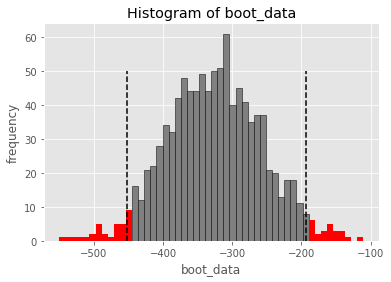

{'boot_data': [-207.27707898089182,
  -314.9554238853501,
  -294.404473566879,
  -330.3789907643312,
  -362.2675289808918,
  -402.6465060509555,
  -283.57962802547775,
  -347.5891834394905,
  -313.4617955414012,
  -247.5987363057326,
  -246.46497611464963,
  -343.885363057325,
  -249.52230254777078,
  -364.74205000000006,
  -305.28344713375793,
  -348.1592464968155,
  -146.71975350318462,
  -340.93313375796174,
  -322.11784649681556,
  -290.86625414012735,
  -375.45860891719735,
  -400.9235802547769,
  -391.3089283439489,
  -315.82166656050936,
  -314.3184808917198,
  -215.9012834394906,
  -307.7229445859873,
  -350.6082929936306,
  -395.75797356687895,
  -339.2579726114649,
  -434.41720987261147,
  -419.68472324840775,
  -325.0223041401273,
  -313.5318563694268,
  -317.47453248407635,
  -205.00956178343938,
  -223.16243343949066,
  -356.6879114649681,
  -417.6560633757962,
  -390.3535140127391,
  -216.47134968152875,
  -322.73567961783453,
  -343.09555573248406,
  -279.05414808917203,

In [60]:
# посмотрим на бутстрэп по ARPPU
# Н0: средний чек платящего юзера в тестовой и контрольной группе значимо не различаются
# Н1: средний чек платящего юзера теста и контроля значимо отличны
get_bootstrap(
    df[(df.grp == 'A')&(df.rev > 0)].rev, # числовые значения первой выборки
    df[(df.grp == 'B')&(df.rev > 0)].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

p-value < 0.05, что позволяет отвергнуть основную гипотезу об отсутствии значимых различий, **у платящих пользователей тестовой группы чек в среднем больше.**

### Выводы: ###
1. Необходимо прояснить ситуацию вокруг 149 юзеров с неактивной оплатой,  
2. Требуется дополнительный анализ системы сплитования юзеров на тест и контроль, а так же уточнение, нет ли путаницы в описании датасета,  
3. Если входные данные верны, то новая система оплаты не побуждает пользователя платить чаще,  
4. С тем же допущением верно то, что если пользователь платит - он платит статистически значимо больше! мы не видим новой системы оплаты, но возможно, что она связана с бонусами или перекрестной лояльностью к партнерам например, или какие-то всплывающие скидки из категории "только сегодня и только сейчас / гипс снимают, клиент уезжает", побуждающие покупать больше. И это статистически значимо.  
После уточнения пп. 1 и 2 новая система может быть расширена на всех пользователей.

## Задание 2. SQL ##

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.
Необходимо написать **оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.**

Дана таблица default.peas:  
- st_id(int) - ID ученика,  
- timest(timestamp) - Время решения карточки,  
- correct(bool) - Правильно ли решена горошина?,  
- subject(text) - Дисциплина, в которой находится горошина

In [1]:
import pandahouse as ph

In [2]:
#объявляем параметры подключения
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

Обратим внимание, что нам доступны данные только за 2 дня 30.10.2021 и 31.10.2021, за март 2020 года усердных учеников мы просто не получим.Однако, сформируем вопрос в соответствии с заданием:

In [89]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT
    st_id,
    SUM(correct) AS sum_pease
FROM (
    SELECT
        st_id,
        toStartOfMonth(timest) AS MonthBegin,
        toInt32(correct) AS correct
    FROM default.peas
    WHERE MonthBegin == toDate('2020-03-01')   
)
GROUP BY st_id
HAVING sum_pease >=20
"""
df = ph.read_clickhouse(query, connection=connection)
df

,st_id,sum_pease


 ## Второе задание SQL ##
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:  
- ARPU (по всем пользователям) 
- ARPAU (по пользователям, решившим больше 10 задач правильно в любых дисциплинах) 
- CR в покупку (по всем пользователям) 
- СR активного пользователя в покупку (юзеры с более 10 задач верных) 
- CR пользователя из активности по математике (subject = ’Math’) в покупку курса по математике (юзеры с решенными верно 2 или больше задач по математике)

**Подзапросы:**  
- Для ARPU и CR нам нужна табличка с айди юзеров, суммами их покупок и тестовыми группами  
- Для ARPAU CR активных нужно выбрать айдишники юзеров, решивших больше 10 задач, и также сджойнить таблицы с покупками и тестовыми группами  
- Для CR математики нужно выбрать айди юзеров, решивших больше 2 задач по математике, и приджойнить к ним покупки математики  

Итог: все айдишники юзера, тестовая группа, сумма покупки, сумма покупки по математике, число решенных задач, число решенных задач по математике

In [6]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
WITH total_money_id AS (SELECT st_id, SUM(money) AS total_money FROM default.final_project_check GROUP BY st_id),
    total_money_math_id AS (SELECT st_id, SUM(money) AS total_money_math FROM default.final_project_check GROUP BY st_id HAVING subject == 'Math'),
    total_peas_id AS (SELECT st_id, SUM(correct) AS total_peas FROM default.peas GROUP BY st_id),
    total_peas_math_id AS (SELECT st_id, SUM(correct) AS total_peas_math FROM default.peas GROUP BY st_id HAVING subject == 'Math')

SELECT
    test_grp,
    SUM(total_money) / COUNT(st_id) AS ARPU,
    SumIf(total_money, total_peas > 10) / countIf(st_id, total_peas > 10) AS ARPAU,
    countIf(total_money>0) / COUNT(DISTINCT st_id) AS CR,
    countIf(st_id, total_money_math>0 AND total_peas > 10) / countIf(st_id, total_peas > 10) AS CR_active,
    countIf(st_id, total_money_math>0 AND total_peas_math >=2) / countIf(DISTINCT st_id, total_peas_math >=2) AS CR_math
FROM
    (SELECT
                    a.st_id AS st_id,
                    a.test_grp AS test_grp,
                    a.total_money AS total_money,
                    a.total_money_math AS total_money_math,
                    a.total_peas AS total_peas,
                    b.total_peas_math AS total_peas_math
    FROM
        (SELECT
                    a.st_id AS st_id,
                    a.test_grp AS test_grp,
                    a.total_money AS total_money,
                    a.total_money_math AS total_money_math,
                    b.total_peas AS total_peas
        FROM    
            (SELECT
                    a.st_id AS st_id,
                    a.test_grp AS test_grp,
                    a.total_money AS total_money,
                    b.total_money_math AS total_money_math
            FROM (SELECT
                    a.st_id AS st_id,
                    a.test_grp AS test_grp,
                    b.total_money AS total_money
                FROM default.studs AS a
                LEFT JOIN total_money_id as b
                ON a.st_id == b.st_id) AS a
            LEFT JOIN total_money_math_id AS b
            ON a.st_id == b.st_id) AS a
        LEFT JOIN total_peas_id AS b
        ON a.st_id == b.st_id) AS a
    LEFT JOIN total_peas_math_id AS b
    ON a.st_id == b.st_id)
GROUP BY test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.983607,10393.700787,0.049180,0.062992,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.166667,0.095238


## Задание 3. Функции ##

Реализовать функции, которые будут:  
- автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться)  
- на основании дополнительных параметров пересчитывать метрики  
- строить графики по получаемым метрикам.  

Предположения исходя их формулировки задачи: 
0. В связи с необходимостью автоматизации я написала даг, который собирает данные, мерджит и возвращает таблицу с метриками. При необходимости таски дага можно переделать в отдельные функции, но тогда сбор будет не автоматический.
1. Дополнительно подгружаемый файл аналогичен 1 заданию и содержит только айдишки добавляемых пользователей и их группы
2. Все файлы лежат по ранее указанным путям
3. Остальная информация - об активностях и оплатах - лежит в уже исследованных файлах df_active_studs и df_checks  

In [67]:
default_args = {
    'owner': 'e.malofeeva',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2022, 7, 31),
    'schedule_interval' : '0 24 * * *'
}


@dag(default_args = default_args, catchup = False)
def update_metrics():
    # таска считывания groups
    @task()
    def get_data_groups():
        req1 = requests.get('https://s856sas.storage.yandex.net/rdisk/68e81c82e181de5daf7388627f052597b13b536aa0a80fef5ee9ed42c29fd847/62ffbd8d/fKqInKw3d7bLFOeFnMGnhLWIS9AmXMMXWGR17A-BkO3-qg5Wp8tUAp7lxoJJvJyG8pjltSuuxShICmGl2FDiJhbsM4PC04KdB-NoZUjfeOOr8npumZHI4midPdWhecNq?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_groups.csv&disposition=attachment&hash=FjLs%2B6AJdyaRoyFMFeL4raj9RoBP3hYIuXfguWvuEGcjdjYEIrmN7ZN/eZ32Z77Cq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=724984&hid=4b9098e1d545e562c779de19f9f64e2f&media_type=spreadsheet&tknv=v2&rtoken=hnecBu3cpsUk&force_default=no&ycrid=na-2b0f5c1337be7f69292be597866703f9-downloader21h&ts=5e69aca10bd40&s=0494cd844e1de7e7cd86ef2596ed29eb129ca6f9be7725452a0c695808e7636a&pb=U2FsdGVkX196IfjqXhBcL2stXy2LnkQ7NVKd0kJLP_0-SOAlIGqhpZytKXChCTr_taw1cyV4-HCoJZq2x7i-IM6Cn1-mjfxFb9VT1BKqfptmlay7nPbkfLszesK5TypY')
        data1 = req1.content
        df_groups = pd.read_csv(BytesIO(data1), header = None, skiprows = 1, names = ['student_id', 'grp'], sep = ';')
        return df_groups
    
        # таска считывания active_studs
    @task()
    def get_data_active_studs():
        req2 = requests.get('https://s432vla.storage.yandex.net/rdisk/3a40f377f696432a2588a986b2af49044dd68afb5b18d69010f8282c1f40f146/62ffbec8/n3N0SQYM2SoDHEJIQgKt2ujEDw5jYN17sSz14UE4iwGyYlrHRmnPoV9WI8mqa1dmF6Qt_88ffG90wBmmEpDhFQ==?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_active_studs.csv&disposition=attachment&hash=zWS0uLxK3MRXd/4/IErmDFQBGvbpGD1qm/aJx/k6EUUtE6DaDI0uGkDT4cHh/WJbq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=65131&hid=3ed23002f82477fd8c7d4a21c17d8034&media_type=spreadsheet&tknv=v2&rtoken=VLQnNMBdZHav&force_default=no&ycrid=na-96300cdc146eb8e9f9841f7d1c03ae4f-downloader11f&ts=5e69adcd74200&s=298f3f9a6a0b4dcfcd30b5e2531375074e1817b4485c4e2acc2cdda94c064471&pb=U2FsdGVkX19nAru0O76sUeX5I7sjU7s3OfVwfBSgj3bVELERwhe44uxz5-Qbg-huJf5HKtETRz_t9FsHXfXWWfoU1L7utUUpsCWTRvpOBWo')
        data2 = req2.content
        df_active_studs = pd.read_csv(BytesIO(data2), header = None, skiprows = 1, names = ['student_id'])
        df_active_studs['activity'] = 'yes'
        return df_active_studs
    
        # таска считывания checks
    @task()
    def get_data_checks():
        req3 = requests.get('https://s251vla.storage.yandex.net/rdisk/2ed0cef7d3eeb388a1cfef16c898d547abd95ff3590fc483208d4d0329f39e40/62ffbf91/n3N0SQYM2SoDHEJIQgKt2psRrG10OKyAasqgpda4iX7NDTSjoP6nmHZtzOqJXgQH436kYOx6cWVM8zgvGq_zHg==?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_checks.csv&disposition=attachment&hash=TeGedpkC9yRvIkaaNDf1zC3bFkr2Kvo9MvW7kYjfHc5svktv83UZ47kn6%2BaauC1pq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=7764&hid=caf94adff3374e1c1a09fba3aae11e50&media_type=spreadsheet&tknv=v2&rtoken=lCY7FQdHOPMD&force_default=no&ycrid=na-5f259d0cfa6acec9fbf8a1703b68f794-downloader2e&ts=5e69ae8d24640&s=5e3efcf73091f37afe750f8ddb7beb1773a95e621febe7d1acb402b6068f975a&pb=U2FsdGVkX19V-bWbgCAsy4qge7CA2oQF6lBXPRtQz-MNZMZkdtcatn1jMBpFi1o_th5_ltM41rhn_qRsTsB_Kcy6rHTqxIQjj_CLNuwylEM')
        data3 = req3.content
        df_checks = pd.read_csv(BytesIO(data3), header = None, skiprows = 1, names = ['student_id', 'rev'], sep = ';')
        return df_checks
    
    # таска считывания add
    @task()
    def get_data_groups_add():
        req4 = requests.get('https://s750sas.storage.yandex.net/rdisk/f06bf3fb0ce3d7ed783c715aa18a0389af6e9d4efa00d64ca5f53aac6182abf1/62ffc01e/fKqInKw3d7bLFOeFnMGnhGAdJ2MSdW82i4_ghmwgsZlWhJkpRytn07Ls4kX484X-lezQy4loqSz9AFrIeHDnv8QEHwKSTiYbb_hzq1q6XQir8npumZHI4midPdWhecNq?uid=0&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_group_add.csv&disposition=attachment&hash=0ertv33lnyTdzTu9NbdN9MtgpuTSXleSHZ%2BvhK85v05jGwJs7DHSrj4ununKsRcfq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=text%2Fplain&owner_uid=125175473&fsize=949&hid=e8dcec35987c367a56f82404a22463b7&media_type=spreadsheet&tknv=v2&rtoken=x7sQvDBvEcVd&force_default=no&ycrid=na-6ae8cf4f9feb8da91b76dd02295986e5-downloader2e&ts=5e69af139c380&s=28a8f791e2b55bce136323bbd03a635c3fae77f3b10cbcaff7b7a06d71e43fd6&pb=U2FsdGVkX18Wzaw8soN5pjC05gU8iWY8NCgpwE3Bgchzktb4Mdsjxki6tJpzFvDFmTxaIG_MODh8nBJa5LDlTyyWkkVUpW84A0_EDWJ33f5Fytt1LWGLsoVjXXtP2sIv')
        data4 = req4.content
        df_groups_add = pd.read_csv(BytesIO(data4), header = None, skiprows = 1, names = ['student_id', 'grp'])
        return df_groups_add

    # таска преобразования фреймов
    @task()
    def union_df(df_groups, df_groups_add, df_checks, df_active_studs):
        df_groups = pd.concat([df_groups, df_groups_add])
        df = df_groups.merge(df_active_studs, how = 'left', on = 'student_id').fillna('no')
        df = df.merge(df_checks, how = 'left', on = 'student_id').fillna(0)
        return df

    # таска расчета метрик
    @task()
    def metrics(df):
       # общее число юзеров
        users_total = df.groupby('grp', as_index = False) \
        .agg({'student_id' : 'nunique'}) \
        .rename(columns = {'student_id' : 'users_total'})

        # число платящих юзеров
        users_rev = df.query('rev > 0') \
        .groupby('grp', as_index = False) \
        .agg({'student_id' : 'nunique'}) \
        .rename(columns = {'student_id' : 'users_with_revenue'})

        # число активных юзеров
        users_active = df.query('activity == "yes"') \
        .groupby('grp', as_index = False) \
        .agg({'student_id' : 'nunique'}) \
        .rename(columns = {'student_id' : 'users_active'})

        # общая сумма платежей всех юзеров
        rev_total = df.groupby('grp', as_index = False) \
        .agg({'rev' : 'sum'}) \
        .rename(columns = {'rev' : 'rev_total'})

        # cумма платежей всех активных пользователей
        users_active_rev = df.query('activity == "yes"') \
        .groupby('grp', as_index = False) \
        .agg({'rev' : 'sum'}) \
        .rename(columns = {'rev' : 'users_active_rev'})

        metrics = users_total.merge(rev_total, how = 'inner', on = 'grp') \
        .merge(users_rev, how = 'inner', on = 'grp') \
        .merge(users_active, how = 'inner', on = 'grp') \
        .merge(users_active_rev, how = 'inner', on = 'grp')

        metrics['CR'] = metrics.users_with_revenue / metrics.users_total
        metrics['ARPAU'] = metrics.users_active_rev / metrics.users_active
        metrics['ARPPU'] = metrics.rev_total / metrics.users_with_revenue

        return metrics.to_csv('metrics.csv')
        
    df_groups = get_data_groups()
    df_active_studs = get_data_active_studs()
    df_checks = get_data_checks()
    df_groups_add = get_data_groups_add()
    df = union_df(df_groups, df_groups_add, df_checks, df_active_studs)
    metrics = metrics(df)
    
update_metrics = update_metrics()

In [102]:
# Функция рисования графиков по полученным метрикам:
def metrics_graph(df):
    sns.set(rc={'figure.figsize':(20,12)})
    fig, axes = plt.subplots(nrows=1, ncols=3)
    sns.barplot(x=df.grp, y=df.CR, ax = axes[0], data=df)
    sns.barplot(x=df.grp, y=df.ARPAU, ax = axes[1], data=df)
    sns.barplot(x=df.grp, y=df.ARPPU, ax = axes[2], data=df)

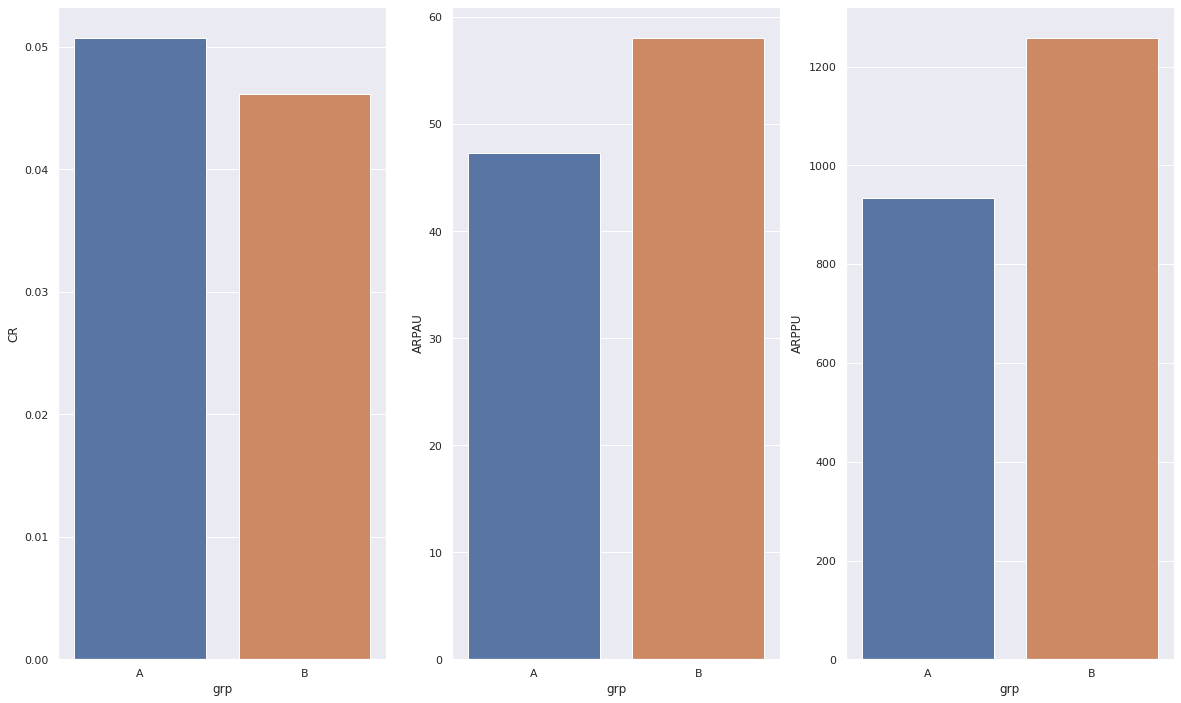

In [103]:
metrics_graph(metrics)